In [1]:
import numpy as np # Imports Python numerical library
import seaborn as sns # Imports Library for drawing heatmaps
import matplotlib.pyplot as plt # Import Library for plotting graphs
from scipy.optimize import linprog # Imports Linear Programming function
from scipy.optimize import linprog_verbose_callback # Imports Linear Programming function
from IPython.display import IFrame # Imports HTML element loader
import time
import networkx as nx
import re 
import cometspy as c
import pandas as pd
import sys

In [2]:
import cobra
from time import sleep

In [77]:
model = cobra.io.read_sbml_model('./iAA1300_C.xml')

### Set the objective to maximize the reaction 'PHBS_syn'

In [4]:

startTime = time.time()
solution = model.optimize()
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Maximum objective = ',solution.objective_value)
print('Status = ',solution.status)


Execution time in seconds: 0.1827256679534912
Maximum objective =  0.9308245166661823
Status =  optimal


In [5]:
model

Name,iAA1300
Memory address,15497dcbe9d0
Number of metabolites,1960
Number of reactions,2289
Number of genes,1300
Number of groups,0
Objective expression,1.0*BIOMASS_Av_DJ_core - 1.0*BIOMASS_Av_DJ_core_reverse_428bc
Compartments,"c, e, p"


In [6]:
model.metabolites.alg_e

Metabolite identifier,alg_e
Name,Alginate
Memory address,0x15497d5a9340
Formula,C6H7O6
Compartment,e
In 3 reaction(s),"BIOMASS_Az_DJ_core_75p37M, EX_alg_e, ALGtex"


In [7]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004845,0,0.00%
cl_e,EX_cl_e,0.004845,0,0.00%
cobalt2_e,EX_cobalt2_e,2.327E-05,0,0.00%
cu2_e,EX_cu2_e,0.00066,0,0.00%
fe2_e,EX_fe2_e,0.007682,0,0.00%
fe3_e,EX_fe3_e,0.007268,0,0.00%
glc__D_e,EX_glc__D_e,15,6,100.00%
h_e,EX_h_e,1.161,0,0.00%
k_e,EX_k_e,0.1817,0,0.00%
mg2_e,EX_mg2_e,0.008075,0,0.00%


In [8]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_fe3_e': 0.05,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 0.05,
 'EX_glc__D_e': 15.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_n2_e': 1000.0}

In [9]:
model.compartments

{'c': '', 'e': '', 'p': ''}

In [10]:
model.reactions.PHBS_syn

Reaction identifier,PHBS_syn
Name,PHB synthetasa
Memory address,0x15497be8a7c0
Stoichiometry,3hbcoa__R_c + phbg_c --> PHB_c + coa_c (R)-3-Hydroxybutyryl-CoA + Growing PHB granule --> PHB granule + Coenzyme A
GPR,Avin_46290 or Avin_23630 or Avin_27080
Lower bound,0.0
Upper bound,1000.0


In [11]:
model.metabolites.get_by_id("phbg_c")

Metabolite identifier,phbg_c
Name,Growing PHB granule
Memory address,0x15497d5a93a0
Formula,R
Compartment,c
In 2 reaction(s),"SK_phbg_c, PHBS_syn"


In [12]:
metabolite = model.metabolites.get_by_id("PHB_c")

In [13]:
G = nx.DiGraph()

# Add the initial metabolite
G.add_node(metabolite.id, type="metabolite")

def add_metabolite_neighbors(G, metabolite):
    # First neighbors
    for rxn in metabolite.reactions:
        if rxn.id not in G.nodes:
            G.add_node(rxn.id, type="reaction")

        if metabolite in rxn.products:
            G.add_edge(rxn.id, metabolite.id)
        else:
            G.add_edge(metabolite.id, rxn.id)

        for met in rxn.metabolites:
            if met.id != metabolite.id:
                if met.id not in G.nodes:
                    G.add_node(met.id, type="metabolite")
                if met in rxn.products:
                    G.add_edge(rxn.id, met.id)
                else:
                    G.add_edge(met.id, rxn.id)
                    
metabolites_of_interest = ["PHB_c", "3hbcoa__R_c", "phbg_c"]

for metabolite in metabolites_of_interest:
    met = model.metabolites.get_by_id(metabolite)
    add_metabolite_neighbors(G, met)

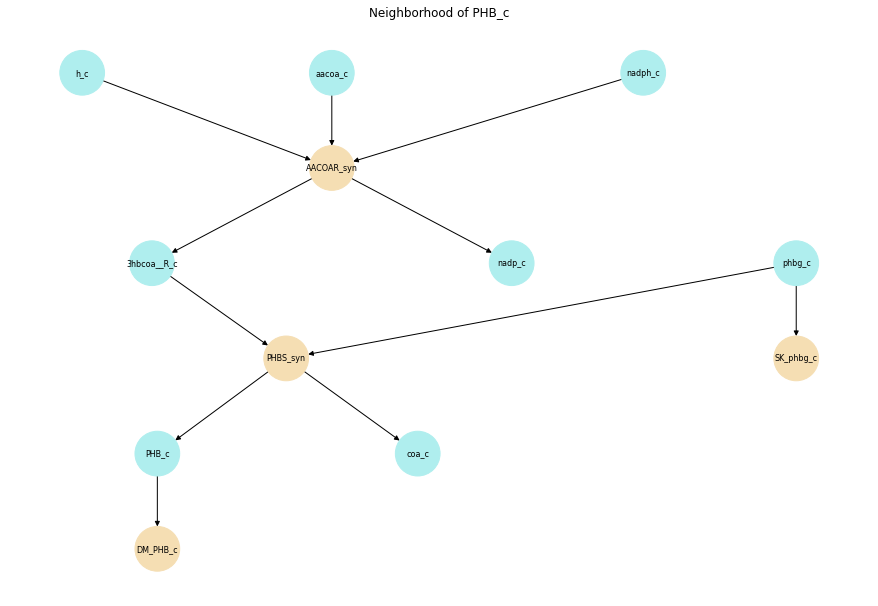

In [14]:
node_colors = []
for node in G.nodes:
    if G.nodes[node].get('type') == "reaction":
        node_colors.append('wheat')
    else:
        node_colors.append('paleturquoise')

plt.figure(figsize=(12, 8))
pos = nx.nx_pydot.pydot_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8, arrows=True, node_color=node_colors)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Neighborhood of PHB_c")
plt.savefig("phb_c_rxn_premod.png")
plt.show()

#### There's an odd floating reaction from no where that requires phbg_c - what is this?

phb_c is the "growing phb granule" - it has an associated sink reaction. Additionally, there is a demand reaction for PHB_c (our target metabolite) which is an abstraction of the cells metabolic demand for PHB (as it used as an energy storage).

These abstractions are reasonable, but the structure of this reaction is not.

In [15]:
test_model = cobra.io.read_sbml_model('Rba_sphCyc_model.xml')

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


In [16]:
test_model.reactions.PHB_synthesis


Reaction identifier,PHB_synthesis
Name,PHB_synthesis
Memory address,0x15497a76ff10
Stoichiometry,CPD-650_c[c] --> CO-A_c[c] + PHB_c[c] (3R)-3-hydroxybutanoyl-CoA --> coenzyme A + Poly-beta-hydroxybutyrate
GPR,
Lower bound,-0.0
Upper bound,1000.0


In [17]:
test_model.metabolites.get_by_id("PHB_c[c]")

Metabolite identifier,PHB_c[c]
Name,Poly-beta-hydroxybutyrate
Memory address,0x15497b6fb4c0
Formula,C20H30O10
Compartment,c
In 2 reaction(s),"EX_PHB_c[c], PHB_synthesis"


In [18]:
metabolite = test_model.metabolites.get_by_id("PHB_c[c]")

G = nx.DiGraph()

# Add the initial metabolite
G.add_node(metabolite.id, type="metabolite")

def add_metabolite_neighbors(G, metabolite):
    # First neighbors
    for rxn in metabolite.reactions:
        if rxn.id not in G.nodes:
            G.add_node(rxn.id, type="reaction")

        if metabolite in rxn.products:
            G.add_edge(rxn.id, metabolite.id)
        else:
            G.add_edge(metabolite.id, rxn.id)

        for met in rxn.metabolites:
            if met.id != metabolite.id:
                if met.id not in G.nodes:
                    G.add_node(met.id, type="metabolite")
                if met in rxn.products:
                    G.add_edge(rxn.id, met.id)
                else:
                    G.add_edge(met.id, rxn.id)
                    
metabolites_of_interest = ["PHB_c[c]", "CPD-650_c[c]"]

for metabolite in metabolites_of_interest:
    met = test_model.metabolites.get_by_id(metabolite)
    add_metabolite_neighbors(G, met)

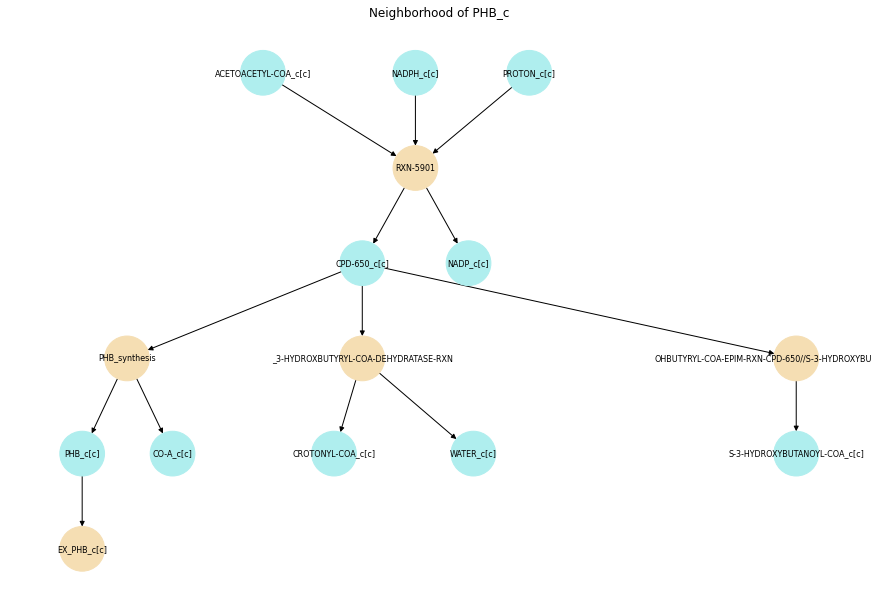

In [19]:
node_colors = []
for node in G.nodes:
    if G.nodes[node].get('type') == "reaction":
        node_colors.append('wheat')
    else:
        node_colors.append('paleturquoise')

plt.figure(figsize=(12, 8))
pos = nx.nx_pydot.pydot_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8, arrows=True, node_color=node_colors)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Neighborhood of PHB_c")
plt.savefig("phb_c_rxn_alt.png")
plt.show()

This is the neighborhood of the function for C. sphaeroides ATCC 17025, specifically PHB synthesis. 
https://rdm.uq.edu.au/files/bc4b6ba0-3abf-4870-9b97-c7578df53a51
from this paper:
https://hal.inrae.fr/hal-04676024v1

This pathway was refined specifically for a scientific question involving phb, so I will trust this format for the reaction as refined in this. Because of this, I will remove the odd phb granule stuff in the azotobacter model.

In [20]:
# Investigate the additional pathways

In [21]:
# Copy the original model to modify


In [78]:
met = model.metabolites.get_by_id('phbg_c')
rxn = model.reactions.get_by_id('SK_phbg_c')

# Remove reaction sink
model.remove_reactions([rxn])

# Remove metabolite granule
model.remove_metabolites([met])

# Modify PHBS_syn to match
#model_mod.reactions.PHBS_syn.add_metabolites({met: 0})

In [23]:
model.reactions.PHBS_syn

Reaction identifier,PHBS_syn
Name,PHB synthetasa
Memory address,0x15497be8a7c0
Stoichiometry,3hbcoa__R_c --> PHB_c + coa_c (R)-3-Hydroxybutyryl-CoA --> PHB granule + Coenzyme A
GPR,Avin_46290 or Avin_23630 or Avin_27080
Lower bound,0.0
Upper bound,1000.0


In [24]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004845,0,0.00%
cl_e,EX_cl_e,0.004845,0,0.00%
cobalt2_e,EX_cobalt2_e,2.327E-05,0,0.00%
cu2_e,EX_cu2_e,0.00066,0,0.00%
fe2_e,EX_fe2_e,0.007682,0,0.00%
fe3_e,EX_fe3_e,0.007268,0,0.00%
glc__D_e,EX_glc__D_e,15,6,100.00%
h_e,EX_h_e,1.161,0,0.00%
k_e,EX_k_e,0.1817,0,0.00%
mg2_e,EX_mg2_e,0.008075,0,0.00%


In [25]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_fe3_e': 0.05,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 0.05,
 'EX_glc__D_e': 15.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_n2_e': 1000.0}

In [26]:
#Updated reaction 

In [27]:
metabolite = model.metabolites.get_by_id("PHB_c")

G = nx.DiGraph()

# Add the initial metabolite
G.add_node(metabolite.id, type="metabolite")

def add_metabolite_neighbors(G, metabolite):
    # First neighbors
    for rxn in metabolite.reactions:
        if rxn.id not in G.nodes:
            G.add_node(rxn.id, type="reaction")

        if metabolite in rxn.products:
            G.add_edge(rxn.id, metabolite.id)
        else:
            G.add_edge(metabolite.id, rxn.id)

        for met in rxn.metabolites:
            if met.id != metabolite.id:
                if met.id not in G.nodes:
                    G.add_node(met.id, type="metabolite")
                if met in rxn.products:
                    G.add_edge(rxn.id, met.id)
                else:
                    G.add_edge(met.id, rxn.id)
                    
metabolites_of_interest = ["PHB_c", "3hbcoa__R_c"]

for metabolite in metabolites_of_interest:
    met = model.metabolites.get_by_id(metabolite)
    add_metabolite_neighbors(G, met)

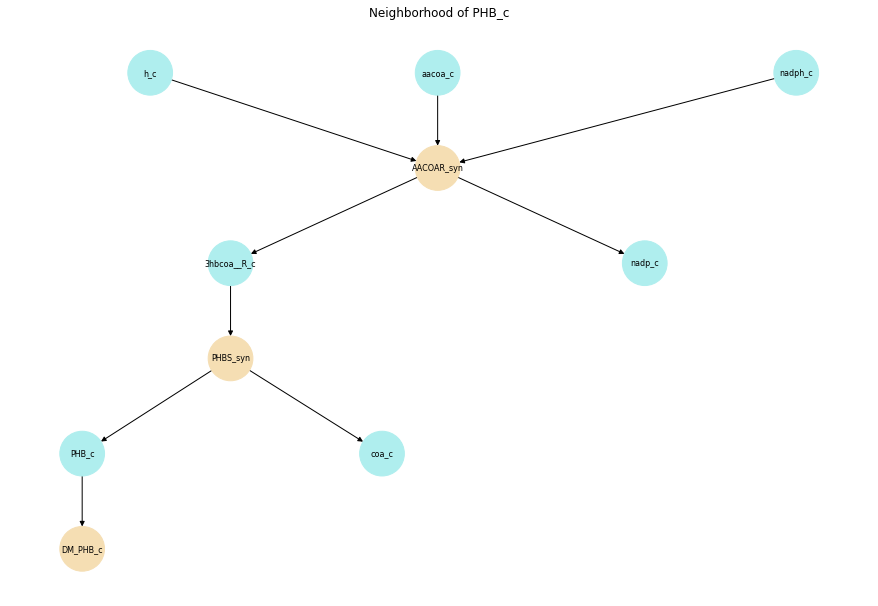

In [28]:
node_colors = []
for node in G.nodes:
    if G.nodes[node].get('type') == "reaction":
        node_colors.append('wheat')
    else:
        node_colors.append('paleturquoise')

plt.figure(figsize=(12, 8))
pos = nx.nx_pydot.pydot_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8, arrows=True, node_color=node_colors)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Neighborhood of PHB_c")
plt.savefig("phb_c_rxn_postmod.png")
plt.show()

### Growth on different substrates

In [29]:
model.objective = {model.reactions.PHBS_syn: 1}
res = model.optimize()
print(res.fluxes['PHBS_syn'])

17.823589138134587


In [30]:
#PHB production under the ATPM 
paths = ['NII_BD_R', 'NI_CO_R']
kos = [['NADH6', 'CYOO2pp', 'FIX'], ['NADH5', 'CYTBDpp', 'FIX']]
couplings = ['partial', 'full']

atpm_vals = pd.read_csv('./data/atpm.csv', index_col=[0, 1]).squeeze()

table_s2 = pd.read_excel('./data/alleman_table_s2.xlsx', index_col=0)
exp_sucrose_rates = table_s2.groupby(['O2_conc', 'Sucrose_uptake_gcdw'], as_index=False).aggregate({'Growth_rate_exp': 'mean'})
exp_sucrose_rates = exp_sucrose_rates.set_index('O2_conc')

pred_phb_syn_rates = []
pred_pathways = []

for path, reacs, coupled in zip(paths, kos, couplings):
    for o2_conc, sucr_rate in exp_sucrose_rates['Sucrose_uptake_gcdw'].items():
        model_c = model.copy()
        model_c.reactions.EX_glc__D_e.bounds = [0, 0]
        model_c.reactions.EX_nh4_e.bounds = [0, 0]
        
        for reac in reacs:
            model_c.reactions.get_by_id(reac).bounds = [0, 0]

        model_c.reactions.EX_sucr_e.bounds = [-sucr_rate, -sucr_rate] # sucrose uptake rate, to match experimental data
        model_c.reactions.ATPM.bounds = [atpm_vals[(coupled, o2_conc)], 1000]  # previously calculated ATPM flux at given O2 conc
        pred_pathways.append(coupled)
        res = model_c.optimize()
        fluxes = res.fluxes
        print(fluxes['PHBS_syn'])
        pred_phb_syn_rates.append(fluxes['PHBS_syn'])


Read LP format model from file /scratch/341162.1.ood/tmpj1b_rkpv.lp
Reading time = 0.01 seconds
: 1959 rows, 4576 columns, 18914 nonzeros
3.0508884328562003
Read LP format model from file /scratch/341162.1.ood/tmpz8xyio0k.lp
Reading time = 0.01 seconds
: 1959 rows, 4576 columns, 18914 nonzeros
3.682986334954111
Read LP format model from file /scratch/341162.1.ood/tmpznrjcc56.lp
Reading time = 0.01 seconds
: 1959 rows, 4576 columns, 18914 nonzeros
4.1227066146743905
Read LP format model from file /scratch/341162.1.ood/tmpuju986uu.lp
Reading time = 0.01 seconds
: 1959 rows, 4576 columns, 18914 nonzeros
7.518552208200526
Read LP format model from file /scratch/341162.1.ood/tmp9m00vet1.lp
Reading time = 0.01 seconds
: 1959 rows, 4576 columns, 18914 nonzeros
9.972122052989887
Read LP format model from file /scratch/341162.1.ood/tmpkh3e6w0c.lp
Reading time = 0.01 seconds
: 1959 rows, 4576 columns, 18914 nonzeros
10.388352651659504
Read LP format model from file /scratch/341162.1.ood/tmpdb9h6

In [31]:
print(pred_phb_syn_rates)

[3.0508884328562003, 3.682986334954111, 4.1227066146743905, 7.518552208200526, 9.972122052989887, 10.388352651659504, 11.242720722612944, 0.6598846563592712, 1.1820524885271209, 3.2157587822333866, 5.854080460555079, 8.080164376638997, 10.636038502513118, 10.855898642373294, 2.9410047154993557, 3.050934785429433, 3.573102617597248, 4.534990729485337, 6.980934785429413, 8.574920799415445, 9.619256463751096, 9.949046673541321, 10.361284435779059, 11.433102617597203, 1.3743698013412453, 4.122621549592995, 6.6784956754671585, 12.092551619523082, 12.532271899243344, 2.226236930793832, 5.194348818905693, 8.931971196528087, 11.487845322402205, 12.31232084687776, 16.352250916807836, 3.210498023875407, 3.8756887916568585, 4.338430195330916, 7.841390154589744, 10.544200071945092, 11.002712468639318, 11.943869493432707, 0.6942240560049573, 1.24372947286788, 3.383908464860287, 6.160356886904568, 8.502985243004456, 11.192669651859863, 11.424040353696848, 3.094758853921345, 3.2104442048399005, 3.759

In [44]:
o2_exp_vs_pred = exp_sucrose_rates.reset_index().copy()
o2_exp_vs_pred = pd.concat([o2_exp_vs_pred, o2_exp_vs_pred]).reset_index(drop = True)
o2_exp_vs_pred['PHB_syn'] = pred_phb_syn_rates
o2_exp_vs_pred['Pathway'] = pred_pathways

In [45]:
print(o2_exp_vs_pred)

    O2_conc  Sucrose_uptake_gcdw  Growth_rate_exp    PHB_syn  Pathway
0        12                 2.01            0.060   3.050888  partial
1        12                 2.24            0.085   3.682986  partial
2        12                 2.40            0.120   4.122707  partial
3        12                 3.79            0.180   7.518552  partial
4        12                 4.91            0.260   9.972122  partial
..      ...                  ...              ...        ...      ...
65      192                 9.89            0.070   5.466175     full
66      192                11.25            0.100   9.399477     full
67      192                12.18            0.160  12.089161     full
68      192                12.48            0.170  12.956801     full
69      192                13.95            0.210  17.208238     full

[70 rows x 5 columns]


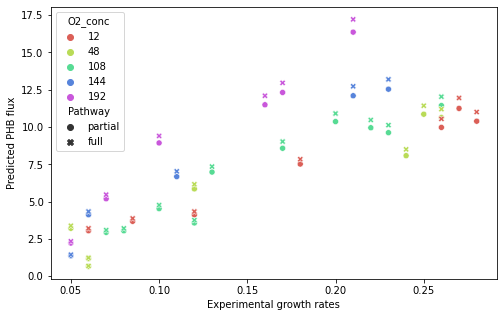

In [67]:

#o2_exp_vs_pred.drop(o2_exp_vs_pred[o2_exp_vs_pred['Pathway'] == "full"].index, inplace=True)
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=o2_exp_vs_pred,
    x='Growth_rate_exp', y='PHB_syn',
    hue='O2_conc',
    style='Pathway',
    markers=True,
    palette = sns.color_palette('hls',5)
)

#grid = sns.lmplot(data=o2_exp_vs_pred, x = 'Growth_rate_exp', y = 'PHB_syn',
#                  hue = 'O2_conc', palette = sns.color_palette("tab10"), facet_kws = { 'xlim': xbounds, 'sharey': 'none', 'sharex': True })
plt.xlabel('Experimental growth rates')
plt.ylabel('Predicted PHB flux')
plt.savefig('predicted_phb_flux_o2.png')

### Mess around with COMETS

In [102]:
#Run comets?


def set_parameters(params, vmax = 3, km = 0.008):
    params.set_param('defaultKm', km)
    params.set_param('defaultVmax', vmax)

    params.set_param("maxSpaceBiomass", 10000)
    params.set_param('numRunThreads', 1)
    params.set_param('timeStep', 0.3333333333333333) #in hrs  
    #convert to a min =. 0.01666666667, 1/3 is 20 min
    params.set_param('spaceWidth',0.5848)
    # in cm - 200ul in .2 cm cubed. third root of .2 - take the 200ul / third root of that express in cm
    params.set_param('maxCycles', 380)
    params.set_param('numRunThreads', 1)
    params.set_param('writeMediaLog', True)
    params.set_param('MediaLogRate', 1)
    #params.set_param('deathRate', 0.01)\
    params.set_param('writeFluxLog', True)
    params.set_param('FluxLogRate', 1)
    
    return params

def set_metabolites(metab_list, test_tube):

    test_tube.set_specific_metabolite('pi_e', 10)
    test_tube.set_specific_metabolite('h_e', 10)
    test_tube.set_specific_metabolite('fe3_e', 10)
    test_tube.set_specific_metabolite('mn2_e', 10)
    test_tube.set_specific_metabolite('fe2_e', 10)
    #test_tube.set_specific_metabolite('glc__D_e', .1)
    test_tube.set_specific_metabolite('zn2_e', 10)
    test_tube.set_specific_metabolite('mg2_e', 10)
    test_tube.set_specific_metabolite('ca2_e', 10)
    test_tube.set_specific_metabolite('ni2_e', 10)
    test_tube.set_specific_metabolite('cu2_e', 10)
    test_tube.set_specific_metabolite('cobalt2_e', 10)
    test_tube.set_specific_metabolite('h2o_e', 10)
    test_tube.set_specific_metabolite('mobd_e', 10)
    test_tube.set_specific_metabolite('so4_e', 10)
    test_tube.set_specific_metabolite('k_e', 10)
    test_tube.set_specific_metabolite('o2_e', 10)
    test_tube.set_specific_metabolite('cl_e', 10)
    test_tube.set_specific_metabolite('n2_e', 10)
    #test_tube.set_specific_metabolite('sucr_e', .1)
    #test_tube.set_specific_metabolite('nh4_e',10)
    #test_tube.set_specific_metabolite('glyc_e', .1)
    
    return test_tube

def setup(cobra_model):
    #Load models
    comets_model = c.model(cobra_model)

    #Open exchanges
    comets_model.open_exchanges()
    #Open bounds for carbon sources:
    #comets_model.change_vmax('EX_glyc_e', 0.1)
    #comets_model.change_vmax('EX_glc__D_e', 0.1)
    #comets_model.change_vmax('EX_sucr_e', 0.1)

    #Set initial population
    init_population =[]
    init_population.append([0,0,5e-6])
    
    comets_model.initial_pop = init_population
    
    return comets_model

def get_metab_vals_sim(BIGG_name, media):
    #Returns list of metabolites concentrations per media cycle.
    metabolites = media.loc[BIGG_name].values
    return metabolites

In [103]:
fluxes = []
growth = []

mets = ['glc__D_e', 'glyc_e', 'sucr_e']
#Change one metabolite at a time
for met in mets:
    test_tube = c.layout()
    test_tube.grid = [1,1]

    comets_model = setup(model)

    test_tube.add_model(comets_model)

    metab_list = list(model.metabolites)

    test_tube = set_metabolites(metab_list, test_tube)

    test_tube.set_specific_metabolite(met, .1)

    params = c.params()

    params = set_parameters(params)

    #Run initial simulation
    simulation = c.comets(test_tube, params)
    simulation.run(False)
    
    fluxes_sim = []
    for i in np.arange(1, 381):
        fluxes_sim.append(simulation.get_flux_image("iAA1300","PHBS_syn",i))
    
    flat = [x.item() for x in fluxes_sim]
    flat.append(flat[-1])
    fluxes.append(flat)
    
    col_name = simulation.total_biomass.columns[1]
    simulation_growth = (simulation.total_biomass[col_name])
    growth.append(simulation_growth)

building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...
Done!


In [95]:
media = simulation.media
media = media.drop(['x','y'],axis=1)
media = media.pivot(index='metabolite', columns='cycle', values='conc_mmol')
media = media.fillna(0)

<Figure size 1440x360 with 0 Axes>

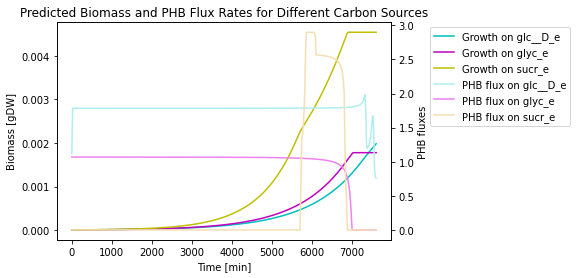

In [138]:
plt.figure(figsize=(20,5))

simulation_time = (simulation.total_biomass["cycle"]*20).tolist()

fig, ax = plt.subplots()

colors=['c','m','y']
colors_alt=['paleturquoise', 'violet','wheat']

lines = []

for i, met in enumerate(mets):
    line, = ax.plot(simulation_time, growth[i], label=f"Growth on {met}", color=colors[i])
    lines.append(line)

ax.set_xlabel('Time [min]')
ax.set_ylabel('Biomass [gDW]')

ax2 = ax.twinx()

for i, met in enumerate(mets):
    line, = ax2.plot(simulation_time, fluxes[i], label=f"PHB flux on {met}", color=colors_alt[i])
    lines.append(line)

ax2.set_ylabel('PHB fluxes')

labels = [line.get_label() for line in lines]

ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.1, 1))

plt.title("Predicted Biomass and PHB Flux Rates for Different Carbon Sources")

fig.subplots_adjust(right=0.9)
plt.savefig('flux_dynamics.png',bbox_inches='tight')

